<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 28

# Student 1: Stan Meijerink, 1222737 

# Student 2: Sam van der Velden, 1017871 

# Student 3: Danylo Vasylyshyn, 1815709

# Downloading Data and Preliminaries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import spacy
import numpy as np

import random
import math
import time

In [ ]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [ ]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [ ]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [ ]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [ ]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [ ]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

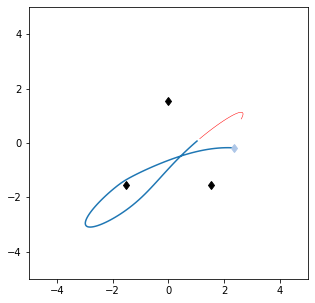

Charges are [-0.42225889 -0.44497807 -0.15911579]


In [ ]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Model Implementation

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout)
        
    def forward(self, simulation_start):
        outputs, (hidden, cell) = self.rnn(simulation_start)
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.input_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers        
        self.rnn = nn.LSTM(self.input_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        prediction = self.fc_out(output)
        
        return prediction[0], hidden, cell

In [ ]:
class SequenceClassification(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 1):
        trg_len = trg.shape[0]
        outputs = torch.zeros(trg_len).to(self.device)
        hidden, cell = self.encoder(src)
        
        input = torch.zeros(3)
        output, hidden, cell = self.decoder(input, hidden, cell)
        return output

## Model Training

In [ ]:
#todo

In [ ]:
INPUT_DIM = 2
OUTPUT_DIM = 3
HID_DIM = 40
N_LAYERS = 1
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0
device = 'cpu'

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

model = SequenceClassification(enc, dec, device).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
optimizer = optim.Adam(model.parameters())


In [ ]:
def train(model, starting_simulation, continuation_of_simulation, optimizer, criterion, clip, teacher_force):
    
    model.train()
    
    epoch_loss = 0
    for i, (src, trg) in enumerate(zip(starting_simulation, continuation_of_simulation)):
        #print(trg.shape)
        src = torch.FloatTensor(src)
        trg = torch.FloatTensor(trg)
        optimizer.zero_grad()
        output = model(src, trg, teacher_force)
        output_dim = output.shape[-1]
        
        output = output.view(output_dim)
        
        loss = criterion(trg, output)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(starting_simulation)

In [ ]:
def evaluate(model, starting_simulation, continuation_of_simulation, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
      for i, (src, trg) in enumerate(zip(starting_simulation, continuation_of_simulation)):

            src = torch.FloatTensor(src)
            trg = torch.FloatTensor(trg)
            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]
            
            output = output.view(output_dim)
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(starting_simulation)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 20
CLIP = 1

adaptive_teacher_force = 0
adaptive_step = (adaptive_teacher_force / N_EPOCHS) / 2
best_valid_loss = float('inf')
criterion = nn.L1Loss()

training_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, simulation_train, charges_train, optimizer, criterion, CLIP, adaptive_teacher_force)
    valid_loss = evaluate(model, simulation_valid , charges_valid, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    #adaptive_teacher_force -= adaptive_step
    training_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

#losses_for_different_parameters_train.append((training_losses, N_EPOCHS, N_LAYERS, HID_DIM))
#losses_for_different_parameters_valid.append((valid_losses, N_EPOCHS, N_LAYERS, HID_DIM))


Epoch: 01 | Time: 0m 19s
	Train Loss: 0.256 | Train PPL:   1.292
	 Val. Loss: 0.253 |  Val. PPL:   1.288
Epoch: 02 | Time: 0m 16s
	Train Loss: 0.235 | Train PPL:   1.266
	 Val. Loss: 0.244 |  Val. PPL:   1.276
Epoch: 03 | Time: 0m 16s
	Train Loss: 0.219 | Train PPL:   1.245
	 Val. Loss: 0.224 |  Val. PPL:   1.251
Epoch: 04 | Time: 0m 16s
	Train Loss: 0.204 | Train PPL:   1.227
	 Val. Loss: 0.220 |  Val. PPL:   1.246
Epoch: 05 | Time: 0m 17s
	Train Loss: 0.188 | Train PPL:   1.207
	 Val. Loss: 0.191 |  Val. PPL:   1.210
Epoch: 06 | Time: 0m 18s
	Train Loss: 0.178 | Train PPL:   1.195
	 Val. Loss: 0.188 |  Val. PPL:   1.206
Epoch: 07 | Time: 0m 16s
	Train Loss: 0.168 | Train PPL:   1.183
	 Val. Loss: 0.175 |  Val. PPL:   1.191
Epoch: 08 | Time: 0m 16s
	Train Loss: 0.160 | Train PPL:   1.173
	 Val. Loss: 0.179 |  Val. PPL:   1.196
Epoch: 09 | Time: 0m 16s
	Train Loss: 0.157 | Train PPL:   1.170
	 Val. Loss: 0.157 |  Val. PPL:   1.170
Epoch: 10 | Time: 0m 16s
	Train Loss: 0.151 | Train PPL

## Evaluation
The idea of the model is quite simple, so to evaluate the performance it's substantial to look at the value loss of the model. We see that on the final epoch it has reached 0.133, which means that the average distance between the predicted and the acutal charges is 0.133.

In [ ]:
charges = model

## Printing the trajectories, for which the model did the worst prediction

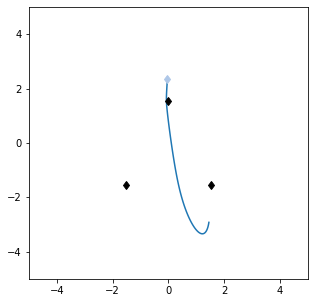

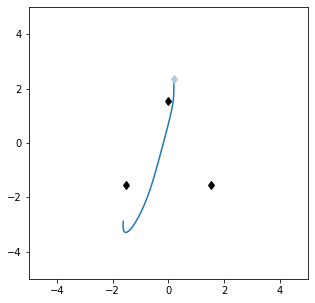

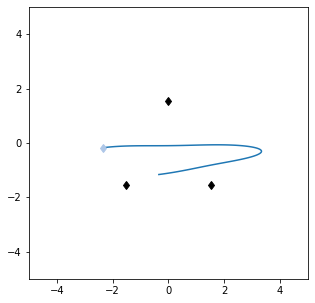

In [ ]:
performance = nn.L1Loss()
for i in range(100):
  actual_charges = charges_test[i]
  predicted_charges = charges(torch.FloatTensor(simulation_test[i]), torch.FloatTensor(actual_charges))
  if(performance(predicted_charges, torch.FloatTensor(actual_charges)) > 0.25):
    plot_example(simulation_test[i], np.array([[0, 0]]))

Apparently, the model is performing worse forthe situations, where the trajectory of the particle does not lie go close to the fixed particles.

# Task 3.2

## Data Handling and Preprocessing

In [ ]:
#todo

In [ ]:
losses_for_different_parameters_train = []
losses_for_different_parameters_valid = []

## Model Implementation

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout)
        #self.dropout = nn.Dropout(dropout)
        
    def forward(self, simulation_start):
        outputs, (hidden, cell) = self.rnn(simulation_start)
        
        return hidden, cell, outputs

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers        
        self.rnn = nn.LSTM(self.input_dim + hid_dim, hid_dim, n_layers, dropout = dropout)

        self.Wa = nn.Linear(hid_dim, 100)
        self.Ua = nn.Linear(hid_dim, 100)
        self.va = nn.Linear(100, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.fc_out = nn.Linear(hid_dim, output_dim)
                
    def forward(self, input, hidden, cell, encoder_ouput):
        #attention mechanism
        eij = self.Wa(hidden[-1]) + self.Ua(encoder_ouput)
        eij = self.tanh(eij)
        eij = self.va(eij)
        ak = self.softmax(eij)
        ci = ak * encoder_ouput
        ci = torch.sum(ci, dim=0)

        #LSTM
        input = torch.cat((input, ci.unsqueeze(0)), dim=1)
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        
        prediction = self.fc_out(output)
        
        return prediction, hidden, cell

In [ ]:
#charges
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 1):
        
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        
        #tensor to store decoder outputs
        
        #outputs = torch.zeros(trg_len, batch_size, 2).to(self.device)
        outputs = torch.zeros(trg_len, 2).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell, encoder_output = self.encoder(src)
        
        #s0 = (self.encoder.weight_hh_l[-1] * )

        #input = src[-int(INPUT_DIM_DECODER/2):].view(1, -1)
        #print(input.shape)
        input = torch.cat((src[-int(INPUT_DIM_DECODER/2):].view(1, -1), charges(src, trg, 0).view(1, -1)), 1)
        #print(input.shape)
        #input.shape()
        for t in range(0, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_output)
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            
            #get the highest predicted token from our predictions
            teacher_force = random.random() < teacher_forcing_ratio
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token

            #autoregressive part(here we pass multiple previous outputs, into the next input)
            temp = torch.zeros(1, INPUT_DIM_DECODER + 3)
            for i in range(INPUT_DIM_DECODER - 2):
              curr = ((t + 1) * 2) + i - INPUT_DIM_DECODER
              if(teacher_force or curr < 0):
                if curr < 0:
                  temp[0, i] = src.view(-1)[curr]
                else:
                  temp[0, i] = trg.view(-1)[curr]
              else:
                temp[0, i] = outputs.view(-1)[curr]
            teacher_force = random.random() < teacher_forcing_ratio
            temp[0, -5:-3] = trg[t] if teacher_force else output[0]
            input = temp
        
        return outputs

## Model Training

In [ ]:
INPUT_DIM = 2
INPUT_DIM_DECODER = 10
OUTPUT_DIM = 2
HID_DIM = 30
N_LAYERS = 3
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
device = 'cpu'

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(INPUT_DIM_DECODER + 3, OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters())


In [ ]:
def train(model, starting_simulation, continuation_of_simulation, optimizer, criterion, clip, teacher_force):
    
    model.train()
    
    epoch_loss = 0
    for i, (src, trg) in enumerate(zip(starting_simulation, continuation_of_simulation)):
        src = torch.FloatTensor(src)
        trg = torch.FloatTensor(trg)
        optimizer.zero_grad()
        output = model(src, trg, teacher_force)
        
        output_dim = output.shape[-1]
        
        output = output.view(-1, output_dim)
        
        real_vels = torch.zeros(trg.shape[0] - 1, trg.shape[1])
        pred_vels = torch.zeros(output.shape[0] - 1, output.shape[1])
        for i in range(real_vels.shape[0]):
          pred_vels[i] = trg[i + 1] - trg[i]
          real_vels[i] = output[i + 1] - output[i]

        loss = torch.mean(criterion(torch.cat((output, pred_vels), dim=0), torch.cat((trg, real_vels), dim=0)))
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(starting_simulation)

In [ ]:

def evaluate(model, starting_simulation, continuation_of_simulation, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
      for i, (src, trg) in enumerate(zip(starting_simulation, continuation_of_simulation)):

            src = torch.FloatTensor(src)
            trg = torch.FloatTensor(trg)
            output = model(src, trg, 0) #turn off teacher forcing


            output_dim = output.shape[-1]
            
            output = output.view(-1, output_dim)

            loss = torch.mean(criterion(output, trg))
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(starting_simulation)

In [ ]:

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 30
CLIP = 1

adaptive_teacher_force = 0
adaptive_step = (adaptive_teacher_force / N_EPOCHS) / 2
best_valid_loss = float('inf')
criterion = nn.PairwiseDistance()

training_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, simulation_train_task32, simulation_continued_train, optimizer, criterion, CLIP, adaptive_teacher_force)
    valid_loss = evaluate(model, simulation_valid , simulation_continued_valid, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    #adaptive_teacher_force -= adaptive_step
    training_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

losses_for_different_parameters_train.append((training_losses, N_EPOCHS, N_LAYERS, HID_DIM))
losses_for_different_parameters_valid.append((valid_losses, N_EPOCHS, N_LAYERS, HID_DIM))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 01 | Time: 0m 32s
	Train Loss: 1.195 | Train PPL:   3.303
	 Val. Loss: 2.334 |  Val. PPL:  10.321
Epoch: 02 | Time: 0m 33s
	Train Loss: 1.160 | Train PPL:   3.191
	 Val. Loss: 2.287 |  Val. PPL:   9.848
Epoch: 03 | Time: 0m 32s
	Train Loss: 1.119 | Train PPL:   3.063
	 Val. Loss: 2.287 |  Val. PPL:   9.848
Epoch: 04 | Time: 0m 32s
	Train Loss: 1.107 | Train PPL:   3.026
	 Val. Loss: 2.260 |  Val. PPL:   9.586
Epoch: 05 | Time: 0m 32s
	Train Loss: 1.083 | Train PPL:   2.954
	 Val. Loss: 1.978 |  Val. PPL:   7.230
Epoch: 06 | Time: 0m 32s
	Train Loss: 0.989 | Train PPL:   2.687
	 Val. Loss: 1.820 |  Val. PPL:   6.173
Epoch: 07 | Time: 0m 32s
	Train Loss: 0.950 | Train PPL:   2.585
	 Val. Loss: 1.800 |  Val. PPL:   6.052
Epoch: 08 | Time: 0m 32s
	Train Loss: 0.905 | Train PPL:   2.472
	 Val. Loss: 1.754 |  Val. PPL:   5.777
Epoch: 09 | Time: 0m 32s
	Train Loss: 0.887 | Train PPL:   2.429
	 Val. Loss: 1.660 |  Val. PPL:   5.259
Epoch: 10 | Time: 0m 32s
	Train Loss: 0.860 | Train PPL

array([2.33422272, 2.28724976, 2.28727464, 2.26026743, 1.97822764,
       1.82020083, 1.80035669, 1.75391596, 1.65991737, 1.80647475,
       1.6368196 , 1.5202384 , 1.54367106, 1.34940853, 1.32450957,
       1.33435444, 1.42504117, 1.39649713, 1.33773146, 1.34915459,
       1.285712  , 1.4637227 , 1.23132301, 1.322068  , 1.38051666,
       1.24531843, 1.21737017, 1.25765574, 1.33149708, 1.17585794])

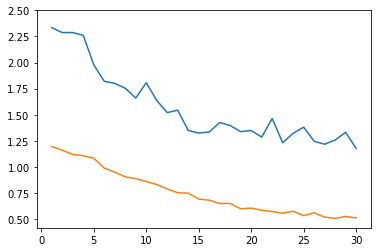

In [ ]:
import seaborn as sns

g= sns.lineplot(y=np.array(valid_losses), x=np.arange(1, len(valid_losses) + 1))
g =sns.lineplot(y=np.array(training_losses), x=np.arange(1, len(training_losses) + 1))
g.set(ylim=(None, 2.5))
np.arange(1, len(training_losses) +1)
np.array(valid_losses)

## Evaluation

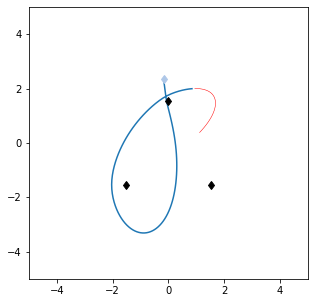

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


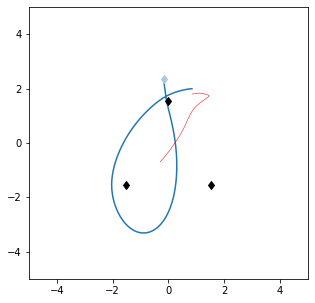

Charges are [-0.89292929 -0.89537468 -0.87927981]


In [ ]:
test_idx = np.random.randint(100)
plot_example(simulation_valid[test_idx], simulation_continued_valid[test_idx])
output = model(torch.FloatTensor(simulation_valid[test_idx]), torch.FloatTensor(simulation_continued_valid[test_idx]), 0)
output = output.view(-1, 2)
plot_example(simulation_valid[test_idx], output.detach().numpy())
print(f'Charges are {charges_train[test_idx]}')

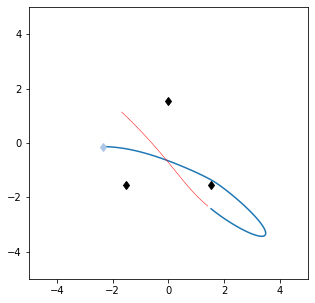

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


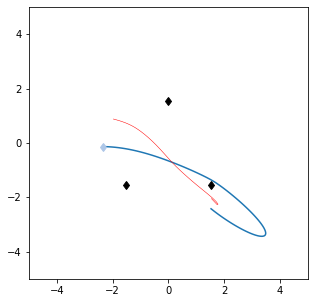

Charges are [-0.35175656 -0.47319647 -0.11388248]


In [ ]:
test_idx = np.random.randint(100)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
output = model(torch.FloatTensor(simulation_train[test_idx]), torch.FloatTensor(simulation_continued_train[test_idx]), 0)
#output = output.view(-1, 2)
#print(output)
#print()
plot_example(simulation_train[test_idx], output.detach().numpy())
print(f'Charges are {charges_train[test_idx]}')

# Comparing with interpolation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


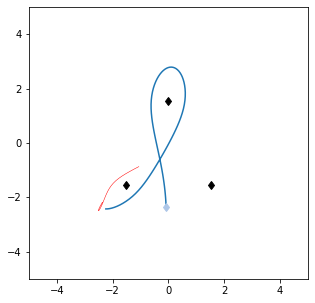

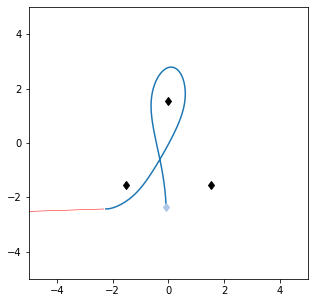

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


average distance for interpolation: 3.3796205520629883
average distance for prediction: 1.1758580207824707


In [ ]:
extrapolation_loss = []
predicted_loss = []

performance = torch.nn.PairwiseDistance()
for i in range(100):
  output = model(torch.FloatTensor(simulation_valid[i]), torch.FloatTensor(simulation_continued_valid[i]), 0)
  extrapolation = np.array([[0, 0], [0, 0]], dtype=np.float)
  extrapolation[0] = simulation_valid[i][-1] + (simulation_valid[i][-1] - simulation_valid[i][-2])
  extrapolation[1] = (extrapolation[0] + (extrapolation[0] - simulation_valid[i][-2]))
  #print(interpolation[0])
  #print(interpolation[1])
  for j in range(2, output.shape[0]):
    extrapolation = np.append(extrapolation, np.array([extrapolation[j-1] + (extrapolation[j-1] - extrapolation[j-2])]), 0)
  #print(interpolation.shape)
  #plot_example(simulation_valid[i], output.detach().numpy())
  #plot_example(simulation_valid[i], interpolation)
  extrapolation_loss.append(torch.mean(performance(torch.FloatTensor(extrapolation), torch.FloatTensor(simulation_continued_valid[i]))))
  predicted_loss.append(torch.mean(performance(torch.FloatTensor(output), torch.FloatTensor(simulation_continued_valid[i]))))
  if(i == 0):
    plot_example(simulation_valid[i], output.detach().numpy())
    plot_example(simulation_valid[i], extrapolation)

  #print(f'Charges are {charges_train[i]}')
print(f"average distance for interpolation: {float(sum(extrapolation_loss) / len(extrapolation_loss))}")
print(f"average distance for prediction: {sum(predicted_loss) / len(predicted_loss)}")
